# Trabalho de conclusão de Curso
Treinamento das redes Alexnet, Densenet e Autoral 

# Configuração
Instalação dos seguintes pacotes
- Tensorflow 2.10
- Matplotlib
- Scipy
- Hyperopt

In [ ]:
# %pip install tensorflow==2.10
# %pip install matplotlib
# %pip install scipy
# %pip install hyperopt
# %pip install keras
# %pip install scikit-learn
# %pip install seaborn

# Implementando

In [5]:
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, BatchNormalization, Activation, Concatenate, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam

from hyperopt import fmin, tpe, hp,Trials,STATUS_OK;
import tensorflow as tf
import numpy as np;
from matplotlib import pyplot;

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [26]:
dataset_dir = './fer2013'
dt_train_dir = os.path.join(dataset_dir,'train')
dt_test_dir = os.path.join(dataset_dir,'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    dt_train_dir,
    target_size=(48,48),
    color_mode= "grayscale",
    class_mode="categorical"
)

validation_generator = test_datagen.flow_from_directory(
    dt_test_dir,
    target_size=(48,48),
    color_mode= "grayscale",
    class_mode="categorical"
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Alexnet

In [7]:
def Alexnet(learning_rate, initializer):
    model = Sequential()
    # kernel 3x3 strides 1x1 padding same
    # Layer 1: Convolutional layer with 64 filters of size 11x11x3
    model.add(Conv2D(filters=64, kernel_size=(4,4), kernel_initializer=initializer, strides=(2,2), padding='valid', activation='relu', input_shape=(48,48,1)))

    # Layer 2: Max pooling layer with pool size of 3x3
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    # Layer 3-5: 3 more convolutional layers with similar structure as Layer 1
    model.add(Conv2D(filters=192, kernel_size=(5,5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    # Layer 6: Fully connected layer with 4096 neurons
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))

    # Layer 7: Fully connected layer with 4096 neurons
    model.add(Dense(7, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    #model.summary()
    return model

## Densenet

In [8]:
def conv_block(x, growth_rate, name):
    """Constrói um bloco convolucional usado em uma DenseNet."""
    x1 = BatchNormalization(name=name + '_bn')(x)
    x1 = Activation('relu', name=name + '_relu')(x1)
    x1 = Conv2D(growth_rate, (3,3), padding='same', name=name + '_conv')(x1)
    x = Concatenate(name=name + '_concat')([x, x1])
    return x

def dense_block(x, num_conv, growth_rate, name):
    """Constrói um bloco denso, consistindo em vários blocos convolucionais."""
    for i in range(num_conv):
        x = conv_block(x, growth_rate, name=name + '_block' + str(i + 1))
    return x

def transition_layer(x, reduction, name):
    """Constrói uma camada de transição para reduzir as dimensões."""
    x = BatchNormalization(name=name + '_bn')(x)
    x = Conv2D(int(tf.keras.backend.int_shape(x)[-1] * reduction), (1,1), padding='same', name=name + '_conv')(x)
    x = AveragePooling2D((2,2), strides=2, name=name + '_pool')(x)
    return x

def create_model(input_shape, num_blocks, num_conv_per_block, growth_rate, reduction, num_classes, initializer):
    """Constrói uma DenseNet."""
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7,7), strides=2, padding='same', name='initial_conv',kernel_initializer=initializer)(inputs)
    x = BatchNormalization(name='initial_bn')(x)
    x = Activation('relu', name='initial_relu')(x)
    x = AveragePooling2D((3,3), strides=2, padding='same', name='initial_pool')(x)
    
    for i in range(num_blocks):
        x = dense_block(x, num_conv_per_block, growth_rate, name='dense_block' + str(i + 1))
        if i != num_blocks - 1:  # Não adicionar camada de transição após o último bloco denso
            x = transition_layer(x, reduction, name='transition_layer' + str(i + 1))
    
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    outputs = Dense(num_classes, activation='softmax', name='fc')(x)
    
    return Model(inputs, outputs, name='densenet')

def DenseNet(learning_rate, initializer):
    # Exemplo de criação de uma DenseNet simplificada
    input_shape = (48, 48, 1)
    num_blocks = 3
    num_conv_per_block = 4
    growth_rate = 32
    reduction = 0.5
    num_classes = 7

    model = create_model(input_shape, num_blocks, num_conv_per_block, growth_rate, reduction, num_classes, initializer)
    #model.summary()
    model.compile(optimizer = Adam(learning_rate), loss = 'categorical_crossentropy', metrics =['accuracy'])

    return model


## Autoral

In [9]:
def Autoral(learning_rate,initializer):
    model = Sequential()

    # CNN LAYER 1
    model.add(Conv2D(input_shape =(48,48,1), filters =128, kernel_size =(3,3), padding = "same", activation = "relu", kernel_initializer=initializer))
    model.add(MaxPooling2D(pool_size =(2,2), strides =(2,2)))
    model.add(Dropout(0.5))
    # CNN LAYER 2
    model.add(Conv2D(filters =64, kernel_size =(3,3), padding = "same", activation = "relu"))
    model.add(MaxPooling2D(pool_size= (2,2), strides=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    # DNN LAYER 1
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    # DNN LAYER 2
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    # DNN LAYER 3
    model.add(Dense(7, activation = 'softmax'))

    # OPT AND LR
    model.compile(optimizer = Adam(learning_rate), loss = 'categorical_crossentropy', metrics =['accuracy'])

    #model.summary()

    return model

# Hyperopt

In [10]:
def hyperopt(create_model):

    def objective(hyperparams):
        model = create_model(learning_rate=hyperparams['learning_rate'],initializer=hyperparams['weight_initialization'])
        result = model.fit(train_generator,
                        validation_data=validation_generator, 
                        epochs=hyperparams['epochs'], 
                        batch_size=hyperparams['batch_size'], 
                        verbose=0)
        val_loss = min(result.history['val_loss']) 
        
        return {'loss': val_loss, 'status': STATUS_OK} 
    
    batch_size_arr = [8, 16, 32, 64, 128]
    epochs_arr = [25, 50, 100, 150]
    weight_initialization_arr = ['glorot_uniform', 'he_normal', 'lecun_normal']

    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
        'batch_size': hp.choice('batch_size', batch_size_arr),
        'epochs': hp.choice('epochs', epochs_arr),
        'weight_initialization': hp.choice('weight_initialization', weight_initialization_arr) 
    }

    trials = Trials()
    best = fmin(objective,
                space=space,
                algo=tpe.suggest,
                max_evals=10, 
                trials=trials) 

    best_values = {
        'learning_rate' : best['learning_rate'],
        'batch_size':  batch_size_arr[best['batch_size']],
        'epochs': epochs_arr[best['epochs']], 
        'weight_initialization': weight_initialization_arr[best['weight_initialization']]
                   }
    
    print(best_values)

    return best_values, trials

In [12]:
best_alexnet, trials_alexnet = hyperopt(Alexnet)
np.save("fase_treinamento_2/trials_alex.npy", trials_alexnet.trials)
# dic = np.load(name, allow_pickle='TRUE')

100%|██████████| 10/10 [6:21:44<00:00, 2290.49s/trial, best loss: 1.0942326784133911]  
{'learning_rate': 0.000248422068699183, 'batch_size': 8, 'epochs': 150, 'weight_initialization': 'lecun_normal'}


In [13]:
best_densenet, trials_densenet = hyperopt(DenseNet)
np.save("fase_treinamento_2/trials_dense.npy", trials_densenet.trials)

100%|██████████| 10/10 [7:36:34<00:00, 2739.46s/trial, best loss: 1.0275566577911377] 
{'learning_rate': 0.0004337574711035279, 'batch_size': 16, 'epochs': 150, 'weight_initialization': 'he_normal'}


In [14]:
best_autoral, trials_autoral = hyperopt(Autoral)
np.save("fase_treinamento_2/trials_autoral.npy", trials_autoral.trials)

100%|██████████| 10/10 [6:07:48<00:00, 2206.89s/trial, best loss: 1.039408802986145]  
{'learning_rate': 0.00016716393601209385, 'batch_size': 16, 'epochs': 150, 'weight_initialization': 'glorot_uniform'}


# Treinamento

In [16]:
def treinar_model(model,best):
    m = model(best['learning_rate'],best['weight_initialization'])
    history = m.fit(
        train_generator,
        validation_data=validation_generator,
        batch_size=best['batch_size'],
        epochs=best['epochs'],
    )

    return history, m 

In [47]:
best_alexnet = {'learning_rate': 0.000248422068699183, 'batch_size': 8, 'epochs': 150, 'weight_initialization': 'lecun_normal'}
history_alexnet, model_alexnet = treinar_model(Alexnet, best_alexnet)

Epoch 1/150
898/898 [==============================] - 241s 267ms/step - loss: 1.7690 - accuracy: 0.2748 - val_loss: 1.5802 - val_accuracy: 0.3734
Epoch 2/150
898/898 [==============================] - 31s 34ms/step - loss: 1.5590 - accuracy: 0.3884 - val_loss: 1.4390 - val_accuracy: 0.4365
Epoch 3/150
898/898 [==============================] - 32s 36ms/step - loss: 1.4515 - accuracy: 0.4377 - val_loss: 1.3765 - val_accuracy: 0.4728
Epoch 4/150
898/898 [==============================] - 32s 36ms/step - loss: 1.3784 - accuracy: 0.4679 - val_loss: 1.3369 - val_accuracy: 0.4883
Epoch 5/150
898/898 [==============================] - 31s 35ms/step - loss: 1.3182 - accuracy: 0.4935 - val_loss: 1.2844 - val_accuracy: 0.5123
Epoch 6/150
898/898 [==============================] - 32s 36ms/step - loss: 1.2796 - accuracy: 0.5127 - val_loss: 1.2306 - val_accuracy: 0.5277
Epoch 7/150
898/898 [==============================] - 31s 34ms/step - loss: 1.2484 - accuracy: 0.5222 - val_loss: 1.2276 - val_

In [28]:
#np.save("fase_treinamento_2/resultado_alexnet",history_alexnet.history)

In [48]:
history_densenet, model_densenet = treinar_model(DenseNet, best_densenet)

Epoch 1/150
898/898 [==============================] - 48s 50ms/step - loss: 1.7219 - accuracy: 0.3128 - val_loss: 1.6190 - val_accuracy: 0.3725
Epoch 2/150
898/898 [==============================] - 35s 39ms/step - loss: 1.5248 - accuracy: 0.4079 - val_loss: 1.4561 - val_accuracy: 0.4480
Epoch 3/150
898/898 [==============================] - 33s 37ms/step - loss: 1.4268 - accuracy: 0.4512 - val_loss: 1.4286 - val_accuracy: 0.4544
Epoch 4/150
898/898 [==============================] - 34s 38ms/step - loss: 1.3583 - accuracy: 0.4788 - val_loss: 1.3427 - val_accuracy: 0.4898
Epoch 5/150
898/898 [==============================] - 32s 36ms/step - loss: 1.3153 - accuracy: 0.4987 - val_loss: 1.3468 - val_accuracy: 0.4843
Epoch 6/150
898/898 [==============================] - 36s 40ms/step - loss: 1.2735 - accuracy: 0.5131 - val_loss: 1.4503 - val_accuracy: 0.4356
Epoch 7/150
898/898 [==============================] - 35s 39ms/step - loss: 1.2421 - accuracy: 0.5257 - val_loss: 1.3337 - val_ac

In [31]:
#np.save("fase_treinamento_2/resultado_densenet",history_densenet.history)

In [17]:
history_autoral, model_autoral = treinar_model(Autoral, best_autoral)

Epoch 1/150
898/898 [==============================] - 288s 319ms/step - loss: 1.8373 - accuracy: 0.2348 - val_loss: 1.8436 - val_accuracy: 0.2471
Epoch 2/150
898/898 [==============================] - 60s 67ms/step - loss: 1.7987 - accuracy: 0.2498 - val_loss: 1.7789 - val_accuracy: 0.2753
Epoch 3/150
898/898 [==============================] - 31s 35ms/step - loss: 1.7612 - accuracy: 0.2710 - val_loss: 1.7000 - val_accuracy: 0.3281
Epoch 4/150
898/898 [==============================] - 31s 35ms/step - loss: 1.7290 - accuracy: 0.2981 - val_loss: 1.6643 - val_accuracy: 0.3568
Epoch 5/150
898/898 [==============================] - 31s 35ms/step - loss: 1.6922 - accuracy: 0.3282 - val_loss: 1.5886 - val_accuracy: 0.3785
Epoch 6/150
898/898 [==============================] - 32s 36ms/step - loss: 1.6566 - accuracy: 0.3485 - val_loss: 1.5326 - val_accuracy: 0.4294
Epoch 7/150
898/898 [==============================] - 32s 35ms/step - loss: 1.6310 - accuracy: 0.3580 - val_loss: 1.4869 - val_

In [32]:
#np.save("fase_treinamento_2/resultado_autoral",history_autoral.history)

# Plotando o gráfico

In [45]:
def plotar_acc_epoch(history,title): 
    pyplot.title(title)
    pyplot.xlabel('Época')
    pyplot.ylabel('Acurácia')
    pyplot.plot(history['accuracy'], label='train') 
    pyplot.plot(history['val_accuracy'], label='val')
    pyplot.legend()
    pyplot.show()

def plotar_loss_epoch(history,title):
    pyplot.title(title)
    pyplot.xlabel('Época')
    pyplot.ylabel('Loss')
    pyplot.plot(history['loss'], label='train') 
    pyplot.plot(history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()

def plotar_matriz_confusao(model, title):
    # Fazendo previsões
    val_steps = validation_generator.samples // validation_generator.batch_size
    y_pred = model.predict(validation_generator, steps=val_steps)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Obtendo as classes verdadeiras
    y_true = validation_generator.classes[:len(y_pred_classes)]

    # Gerando a matriz de confusão
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Exibindo a matriz de confusão
    print(conf_matrix)

    # Plotando a matriz de confusão
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    pyplot.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
    pyplot.xlabel('Previsto')
    pyplot.ylabel('Classificação correta')
    pyplot.title('Matriz de Confusão - '+title)
    pyplot.show()

In [20]:
def plotar_hyperopt(trials_alexnet,trials_densenet,trials_autoral):
    dic_trials = trials_alexnet.trials
    dic_trials2 = trials_densenet.trials
    dic_trials3 = trials_autoral.trials

    losses = [trial['result']['loss'] for trial in dic_trials]
    losses2 = [trial['result']['loss'] for trial in dic_trials2]
    losses3 = [trial['result']['loss'] for trial in dic_trials3]

    # Plotar gráfico
    pyplot.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b', label='Alexnet')
    pyplot.plot(range(1, len(losses2) + 1), losses2, marker='o', linestyle='-', color='r', label='Densenet')
    pyplot.plot(range(1, len(losses3) + 1), losses3, marker='o', linestyle='-', color='g', label='Autoral')
    pyplot.xlabel('Trial')
    pyplot.ylabel('Loss')
    pyplot.title('Hyperopt')
    pyplot.grid(True)
    pyplot.legend()
    pyplot.show()

In [43]:
def plotar_distribuicao(generator):
    # Contar o número de imagens por classe no conjunto de treinamento
    class_counts = np.zeros(len(generator.class_indices))
    for class_idx in generator.classes:
        class_counts[class_idx] += 1

    # Nomes das classes
    class_names = list(generator.class_indices.keys())

    # Plotar gráfico da distribuição de imagens no conjunto de treinamento
    pyplot.figure(figsize=(12, 6))
    pyplot.bar(class_names, class_counts)
    pyplot.title('Distribuição de Imagens por emoção')

    # Adicionar número exato no topo de cada barra
    for i, count in enumerate(class_counts):
        pyplot.text(i, count + 5, int(count), ha='center', va='bottom')

    pyplot.tight_layout()
    pyplot.show()

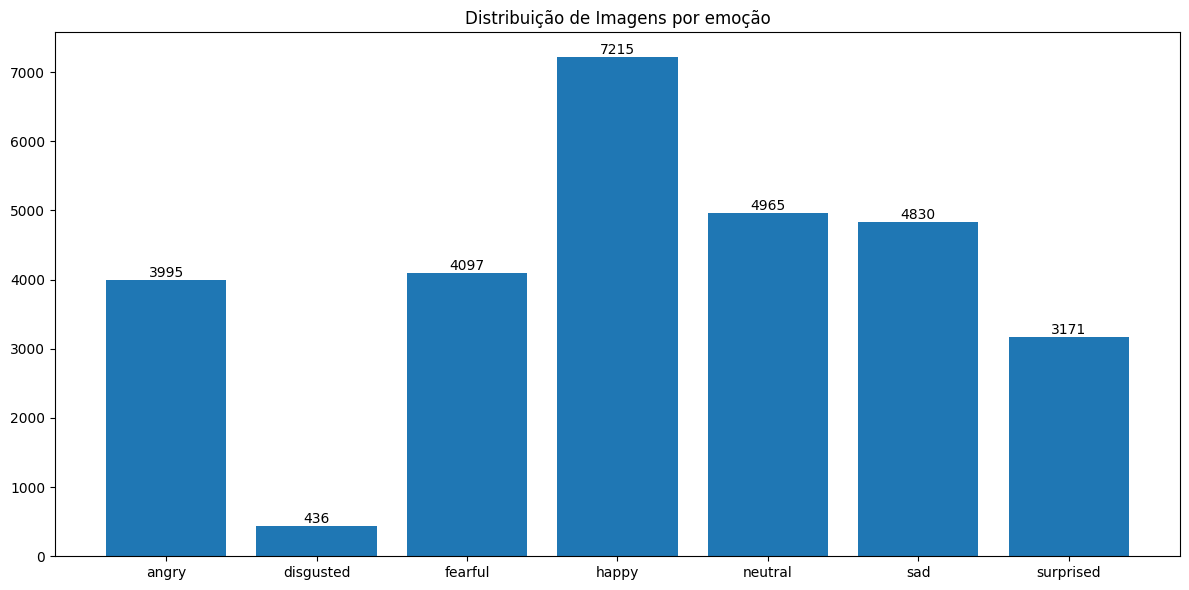

In [44]:
plotar_distribuicao(train_generator)

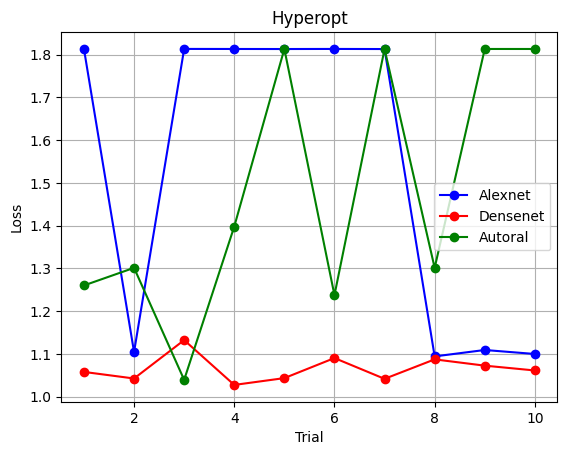

In [21]:
plotar_hyperopt(trials_alexnet,trials_densenet,trials_autoral)

## Alexnet 
- Acurária x Epoca
- Loss x Epoca

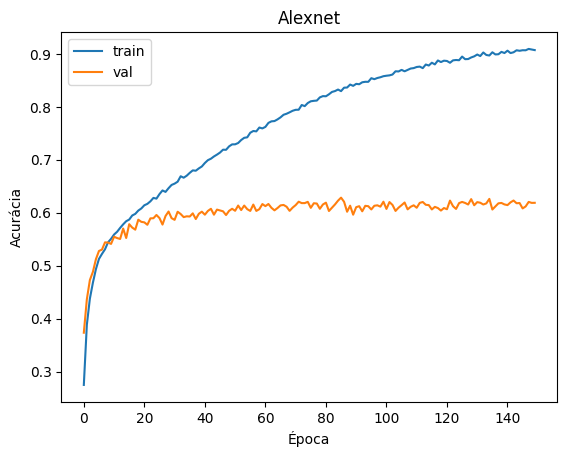

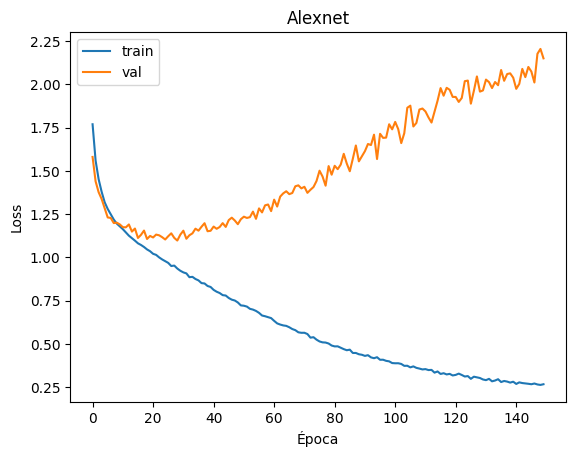

224/224 [==============================] - 5s 23ms/step
[[149   4 128 237 169 148 123]
 [ 20   2  11  31  16  18  13]
 [172   8 125 249 190 160 120]
 [260  24 232 449 280 304 225]
 [201  17 155 289 214 195 162]
 [201  12 178 258 206 219 173]
 [121   9 111 179 143 143 115]]


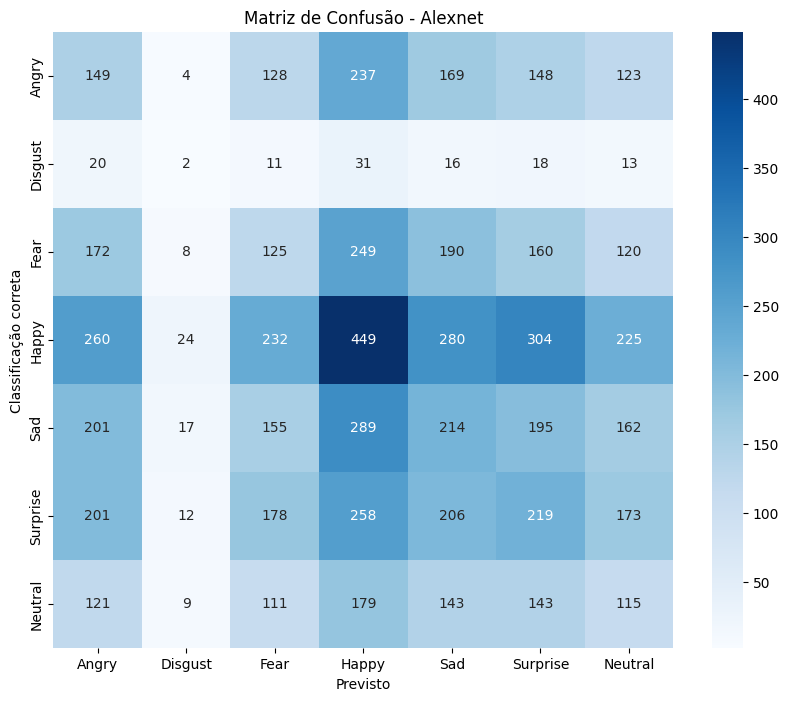

In [49]:
plotar_acc_epoch(history_alexnet.history,"Alexnet")
plotar_loss_epoch(history_alexnet.history,"Alexnet")
plotar_matriz_confusao(model_alexnet,"Alexnet")

## Densenet
- Acurária x Epoca
- Loss x Epoca

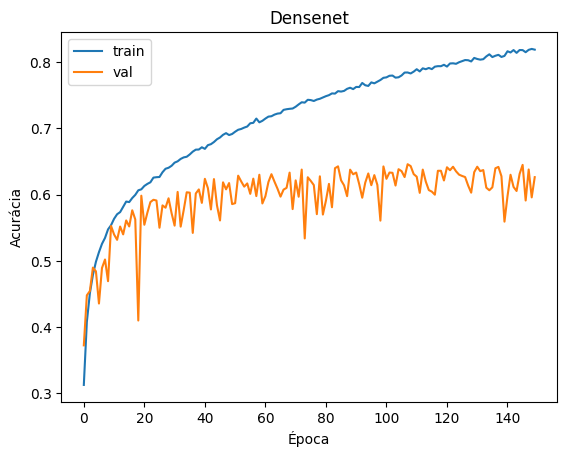

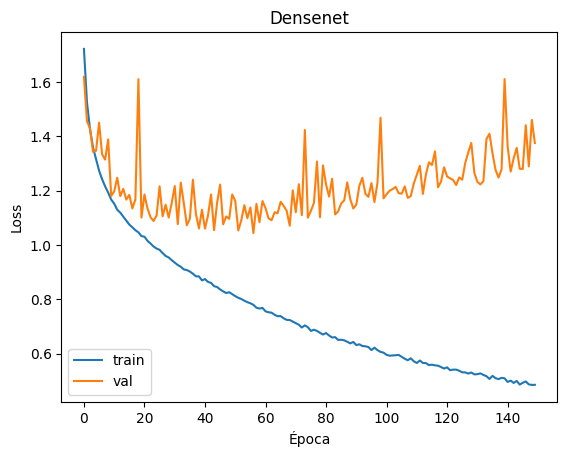

224/224 [==============================] - 5s 18ms/step
[[130  13 139 225 153 190 108]
 [ 25   0  16  22  19  18  11]
 [134  14 180 248 152 176 120]
 [256  27 258 366 320 321 226]
 [194  14 160 285 203 231 146]
 [210  15 173 282 200 242 125]
 [123  11  97 186 146 151 107]]


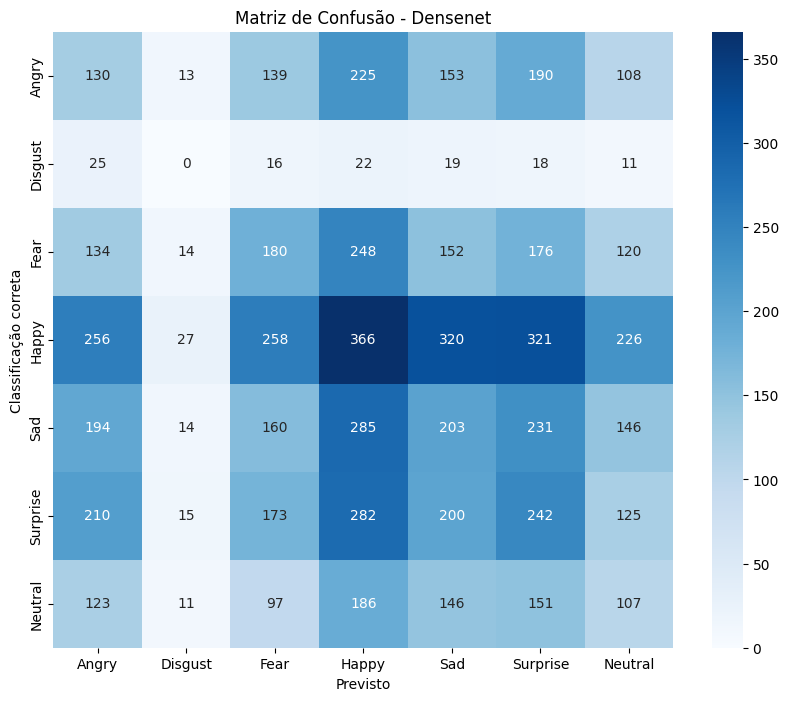

In [50]:
plotar_acc_epoch(history_densenet.history,"Densenet")
plotar_loss_epoch(history_densenet.history,"Densenet")
plotar_matriz_confusao(model_densenet,"Densenet")

## Autoral
- Acurária x Epoca
- Loss x Epoca

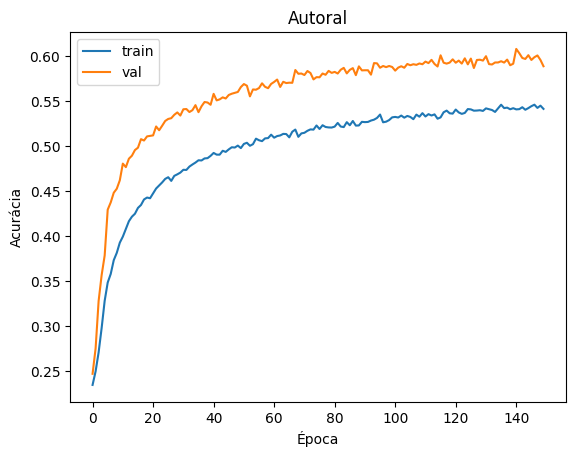

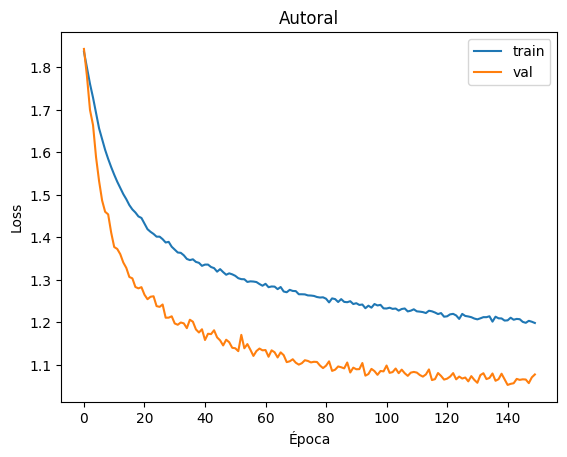

224/224 [==============================] - 4s 17ms/step
[[143   7  64 292 213  98 141]
 [ 12   0   5  28  29  17  20]
 [154   5  68 287 215 116 179]
 [277  11 100 467 439 207 273]
 [174   8  87 329 292 137 206]
 [180   8  73 339 281 173 193]
 [131   3  49 220 199  93 126]]


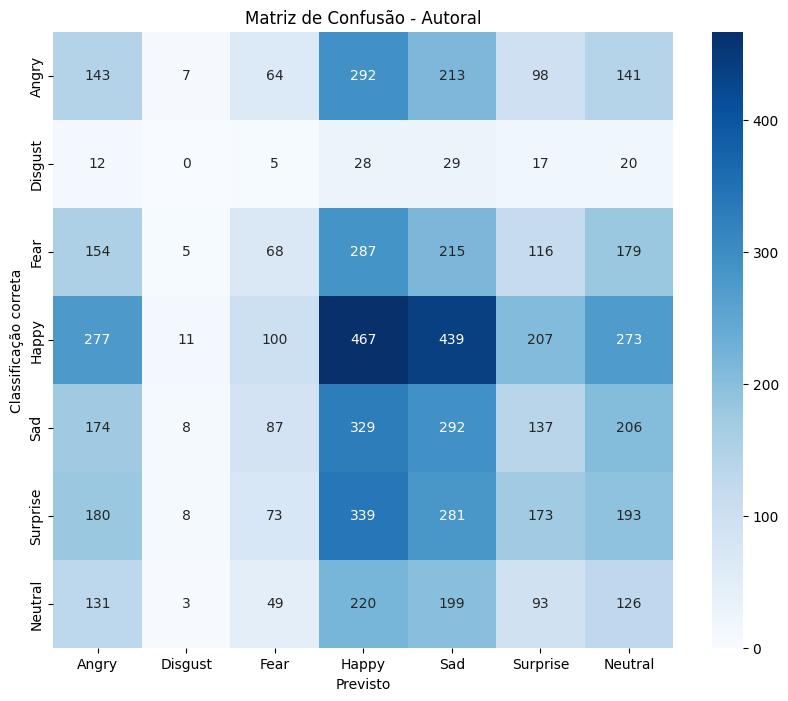

In [46]:
plotar_acc_epoch(history_autoral.history,"Autoral")
plotar_loss_epoch(history_autoral.history,"Autoral")
plotar_matriz_confusao(model_autoral,"Autoral")